For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Zhen Guo (CS6120) and Vikram Chowdhary (CS4120)__

Step 1: Train your own word embeddings
--------------------------------

We chose to use the provided Spooky Author dataset. It contains text from works of fiction written by "spooky authors" of the public domain - Edgar Allan poe, HP Lovecraft, and Mary Shelley. The features in this dataset are:
- id - a unique identifier for each sentence
- text - some text written by one of the authors
- author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)
The training portion of this dataset has 19579 texts, and the testing portion has 8392

Describe what data set you have chosen to compare and contrast with the your chosen provided dataset. Make sure to describe where it comes from and it's general properties.

The dataset we selected was found on Kaggle, and consists of 50,000 IMDB reviews. https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews The features in this dataset are:
- review - a review of a movie that has been posted on IMDB
- sentiment - whether the content of this review is 'positive' or 'negative'

In [1]:
# import your libraries here
import pandas as pd
import nltk
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
# !pip install gensim

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vikramc18/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 0) Pre-processing and text-normalization

The following pre-processing steps are inspired from https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646.

We also pre-processed data so that it begins with < s> tokens (and ends with < /s> tokens). Inspired from answer: https://stackoverflow.com/questions/37605710/tokenize-a-paragraph-into-sentence-and-then-into-words-in-nltk

In [2]:
# normalize text to regular expression
# code from https://gist.github.com/yamanahlawat/4443c6e9e65e74829dbb6b47dd81764a

replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]

patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]

def replace(text):
    s = text
    for (pattern, repl) in patterns:
        s = re.sub(pattern, repl, s)
    return s

In [3]:
def process_text(text):
    """
    Process the paragram so it is tokenized into sentences, 
    each sentence start with <s> end withh </s>, words are tokenized and normalized for each sentence.
    """
    sent_text = nltk.sent_tokenize(text) # this gives us a list of sentences
    
    # now loop over each sentence and tokenize it separately
    s = []
    for sentence in sent_text:
        # regualr expression
        sentence = replace(sentence)
        # tokenize sentence
        tokenized_text = nltk.word_tokenize(sentence)

        # lematizing and stemming words
        ps = SnowballStemmer("english")
        lemmatizer = WordNetLemmatizer()
        
        new_sent = ['<s>']
        for word in tokenized_text:
            # now remove punctuation
            if not word.isalpha():
                continue           
            # stemming:
            word = ps.stem(word)
            # lemmatizing
            word = lemmatizer.lemmatize(word)
            new_sent.append(word)

        # add begin and end
        new_sent.append('</s>')
        s = s + new_sent
    return s

def process_data(series):
    # returns text in this format:
    # data = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
    # 			['this', 'is', 'the', 'second', 'sentence'],
    # 			['yet', 'another', 'sentence'],
    # 			['one', 'more', 'sentence'],
    # 			['and', 'the', 'final', 'sentence']]
    sentences = []
    for _,row in series.items():
        sentences.append(process_text(row))
    
    return sentences

In [4]:
# nltk.download('omw-1.4')

# Read the file and prepare the training data 
# so that it is in the following format
spooky_authors_train = pd.read_csv('./spooky-author-identification/train.csv')
spooky_authors_test = pd.read_csv('./spooky-author-identification/test.csv')
df_imdb = pd.read_csv('IMDB_dataset.csv')

given_data_train = process_data(spooky_authors_train['text'])
given_data_test = process_data(spooky_authors_test['text'])
our_data = process_data(df_imdb['review'])

### a) Train embeddings on GIVEN dataset

In [5]:
from gensim.models import Word2Vec

# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
# sg = 1
# window = 5
# size = EMBEDDINGS_SIZE
# min_count = 1
# train model on spooky authors training data
model = Word2Vec(sentences = given_data_train, 
                 vector_size = EMBEDDINGS_SIZE,
                 sg = 1, 
                 window = 5,  
                 min_count = 1)

In [6]:
# if you save your Word2Vec as the variable model, this will 
# print out the vocabulary size
# https://stackoverflow.com/questions/35596031/gensim-word2vec-find-number-of-words-in-vocabulary
print('Vocab size {}'.format(len(model.wv)))

Vocab size 14996


In [7]:
# You can save file in txt format, then load later if you wish.
# model.wv.save_word2vec_format('embeddings.txt', binary=False)

### b) Train embedding on YOUR dataset

In [8]:
# then do a second data set
# given data is roughly 70/30 train/test
our_data_train = our_data[:35000]
our_data_test = our_data[35000:]
our_model = Word2Vec(sentences = our_data_train, 
                     vector_size = EMBEDDINGS_SIZE,
                     sg = 1, 
                     window = 5,  
                     min_count = 1)

In [9]:
print('Vocab size {}'.format(len(our_model.wv)))

Vocab size 56862


In [10]:
# You can save file in txt format, then load later if you wish.
# our_model.wv.save_word2vec_format('imdb_embeddings.txt', binary=False)

What text-normalization and pre-processing did you do and why? __Sentence begin and end, regular expression expansion, tokenization, punctuation removing, lemmatizing and stemming__

Step 2: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [11]:
#https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook
# visualizing spooky words
def tsne_plot(_model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in _model.wv.vocab:
        tokens.append(_model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [12]:
from sklearn.manifold import TSNE
import numpy as np

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# % matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [14]:
# based on 
# https://hedges.belmont.edu/scottergories/jupyter/2020/05/31/Visualizing-Word2Vec-Word-Embeddings-Using-tSNE.html
def tsne_plot_keys(keys, model, plot_title, img_name):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in model.wv.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    tsne_plot_similar_words(plot_title, keys, embeddings_en_2d, word_clusters, 0.7, img_name)

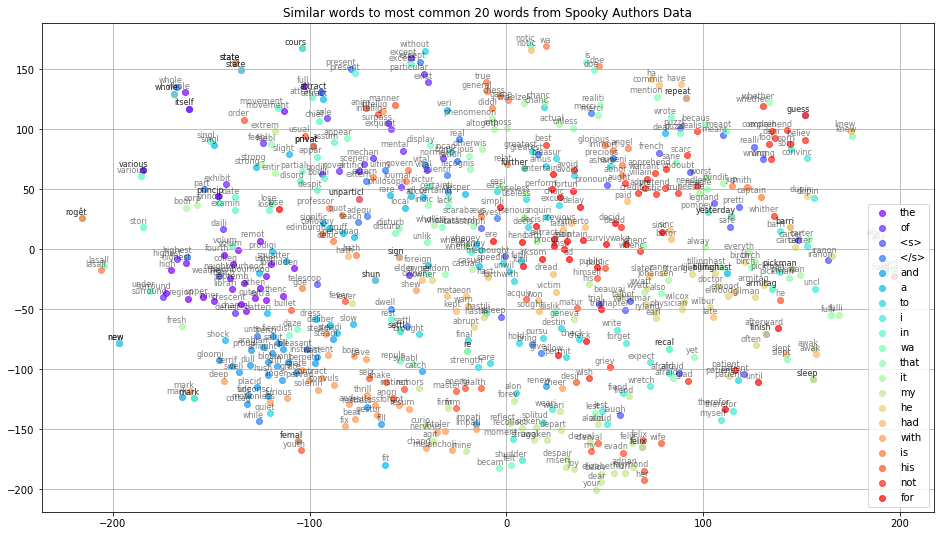

In [15]:
tsne_plot_keys(model.wv.index_to_key[:20], 
               model, 
               'Similar words to most common 20 words from Spooky Authors Data', 
               'spooky_similar_words_most.png')

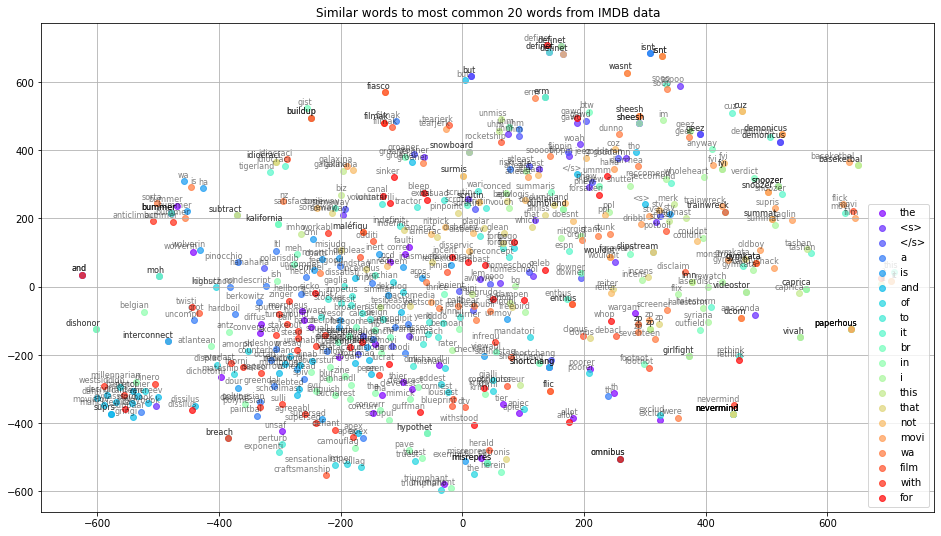

In [16]:
tsne_plot_keys(our_model.wv.index_to_key[:20], 
               our_model, 
               'Similar words to most common 20 words from IMDB data', 
               'imdb_similar_words_most.png')

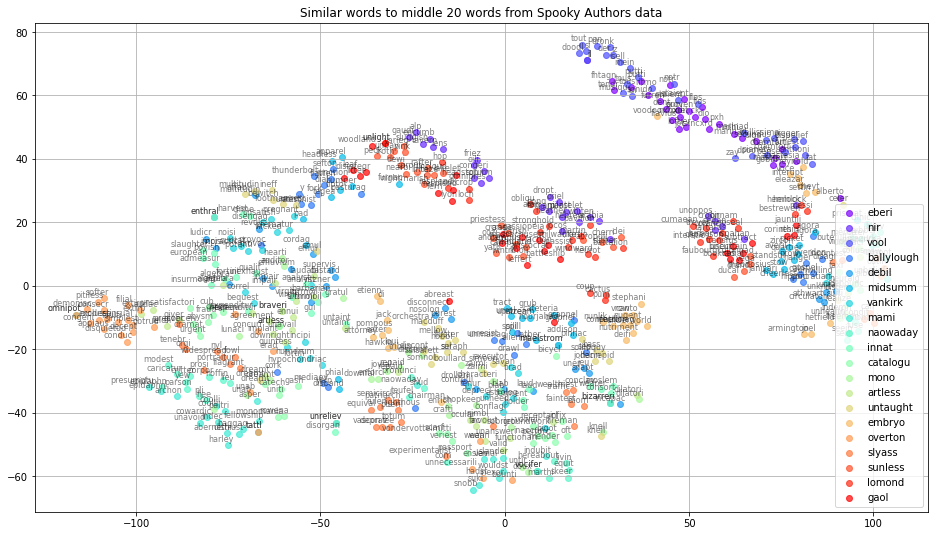

In [17]:
tsne_plot_keys(model.wv.index_to_key[7490:7510],
               model,
               'Similar words to middle 20 words from Spooky Authors data',
               'spooky_similar_words_middle.png')

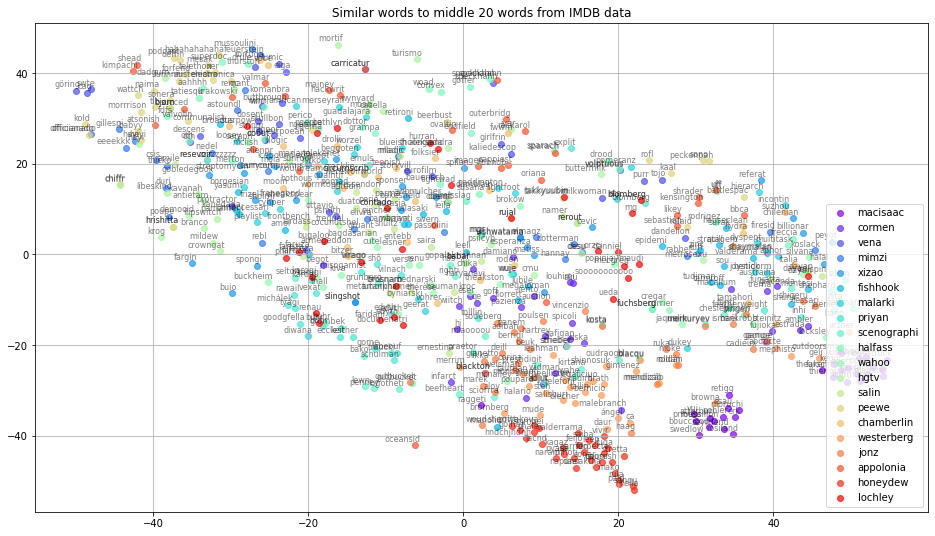

In [18]:
tsne_plot_keys(our_model.wv.index_to_key[28420:28440],
               our_model,
               'Similar words to middle 20 words from IMDB data',
               'imdb_similar_words_middle.png')

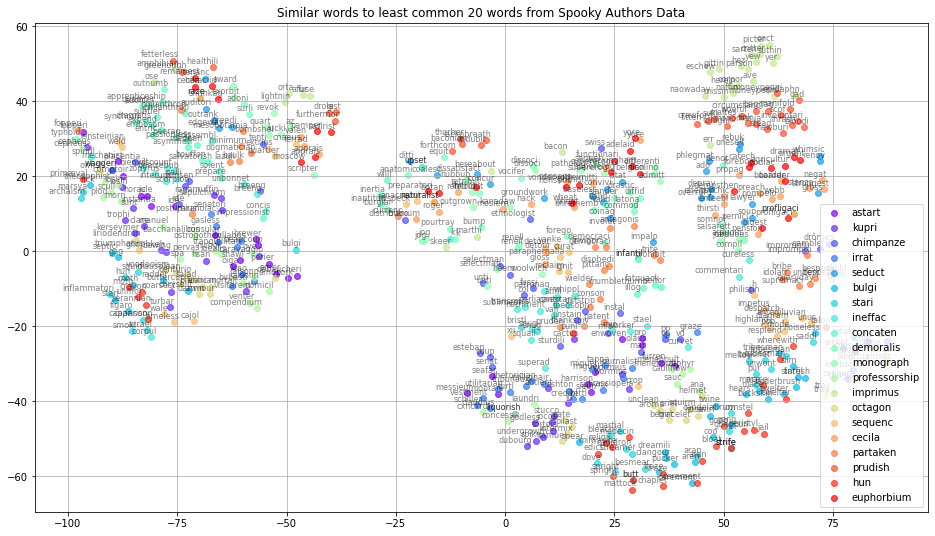

In [19]:
tsne_plot_keys(model.wv.index_to_key[-20:],
               model,
               'Similar words to least common 20 words from Spooky Authors Data',
               'spooky_similar_words_least.png')

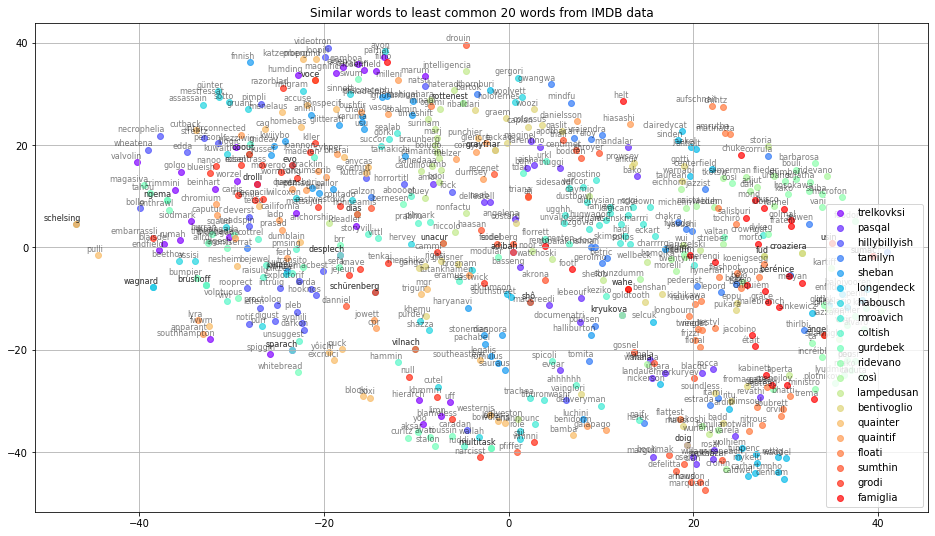

In [20]:
tsne_plot_keys(our_model.wv.index_to_key[-20:],
               our_model,
               'Similar words to least common 20 words from IMDB data',
               'imdb_similar_words_least.png')

## Write down your analysis:

From the visualizations above, it is apparent that the most common words in both data sets are fairly similar - many of them are common words like "the", "of", and "and", which makes sense due to the fact that that both datasets are of text written in the English language. However, we can see that the vectors that are related to these words differ - in the case of the IMDB data, words like "spoilerish" and "filmmaker" appear in the plot of words related to the most common words in the dataset, and for the Spooky Authors data, we see words such as "danger", "disturb", and "death", which indicate that the contents of both datasets are about vastly different subject matter, something we would not have been able to tell simply from looking at lists of the most common words in each dataset. This trend becomes more apparent as we look at the next plots, which display the middle 20 words from each dataset, and finally the least common 20 words.

Another fact that can be observed from these plots is the way the shapes of the distribution of similar words changes as the original words become less common in their respective datasets - while the IMDB dataset's related words tend to stay in one cluster as the source words become less common, the related words from the Spooky Authors dataset start to spread into separate clusters. This can be attributed to the fact that just three authors' writing makes up the entirety of the Spooky Authors set, while thousands or tens of thousands of authors have contributed to the IMDB dataset. Due to this fact, the it could be possible that the Spooky Authors' personal styles of writing have created these clusters - each author is likely to use at least a few uncommon words that the others do not, meaning that the vectors of each author's uncommon words are more closely related to other vectors that appear more often in that author's writing than the others'. On the other hand, due to the high number of unique authors who contributed to the IMDB dataset, it would be impossible to discern which users tend to use which uncommon words from the amount of reviews that a single author could have contributed, meaning that there are no such strong similarities or clustering exist amongst uncommon words in this dataset

Cite your sources:
-------------

- https://hedges.belmont.edu/scottergories/jupyter/2020/05/31/Visualizing-Word2Vec-Word-Embeddings-Using-tSNE.html
- https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook

Step 3: Feedforward Neural Language Model
--------------------------

# a) First, encode  your text into integers

In [21]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding



In [22]:
# The size of the ngram language model you want to train
# change as needed for your experiments
N_GRAM = 2

spooky_tokenizer = Tokenizer()
imdb_tokenizer = Tokenizer()

# spooky authors data
# use out own tokenizer
spooky_train_list = given_data_train
spooky_tokenizer.fit_on_texts(spooky_train_list)
spooky_train_encoded = spooky_tokenizer.texts_to_sequences(spooky_train_list)

# # our data
imdb_train_list = our_data[:35000]
imdb_tokenizer.fit_on_texts(imdb_train_list)
imdb_train_encoded = imdb_tokenizer.texts_to_sequences(imdb_train_list)

### b) Next, prepare your sequences from text

#### Fixed ngram based sequences 

In [23]:
import itertools

In [24]:

def generate_ngram_training_samples(ngram_len: int, data: list) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    up to you, we've put in what we used
    but you can add/remove as needed
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    # TODO: does this make sense????

    combined_text = list(itertools.chain.from_iterable(data))
    final_ngrams = []
    for idx in range(len(combined_text) - ngram_len + 1):
        ngram_list = list(combined_text[idx:idx+ngram_len])
        final_ngrams.append(ngram_list)
        
    return final_ngrams


### c) Then, split the sequences into X and y and create a Data Generator

In [25]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]
def split_ngrams(ngram_list: list) -> list:
    x = [] #those are the context words that we need to get embeddings for
    y = []
    for ngram in ngram_list:
        y.append(ngram[-1])
        x.append(ngram[:-1])
    return x, y

In [26]:
import string

def read_embeddings(text, embeddings, tokenizer):
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    
    I updated this function so that it takes a list of words as input,
    instead of the raw list of list.
    '''
    
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':[0....], ...}
    # index to embedding : {1:[0....], ...} 
    # use your tokenizer's word_index to find the index of
    # a given word
    word_to_embedding = dict()
    index_to_embedding = dict()
    tok_w_i = tokenizer.word_index
    for word in text:
        # since we already pre processed data, we no longer need to transform
        if word not in word_to_embedding.keys():
            word_to_embedding[word] = embeddings.wv[word]
            index_to_embedding[tok_w_i[word]] = embeddings.wv[word]
                
    return word_to_embedding, index_to_embedding

In [27]:
import numpy as np
def data_generator(X: list, y: list, num_sequences_per_batch: int, embeddings, tokenizer) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    generator uses yield instead of return
    '''
    # IDEA: yield num_sequences_per_batch of X, and the same number of y
    # transform y to one hot encodings
    # assume X, y are lists of text/words/whatever comes out of split_ngrams
    cur_idx = 0
    tok_w_i = tokenizer.word_index
    while cur_idx <= len(X) - num_sequences_per_batch:
        X_temp = X[cur_idx:cur_idx + num_sequences_per_batch]
        y_temp = y[cur_idx:cur_idx + num_sequences_per_batch]
        
        # assuming below version of embeddings, one hot encodings is correct
        # otherwise keras.preprocessing has a one_hot function that can be used
        X_out = []
        y_out = []
        
        for idx in range(len(X_temp)):
            # get embeddings for words in X
            w_2_e, i_2_e = read_embeddings(X_temp[idx], embeddings, tokenizer)
            X_out += list(w_2_e.values())
            
            # get one-hot for words in y
            word_y = y_temp[idx]
            y_vect = [0] * len(tok_w_i)
            y_vect[tok_w_i[word_y]] = 1
            y_out.append(y_vect)
        
        cur_idx += num_sequences_per_batch
        yield np.array(X_out), np.array(y_out)


In [28]:
# Examples
spooky_n_gram_temp = generate_ngram_training_samples(2, spooky_train_list)
X, y = split_ngrams(spooky_n_gram_temp)
# initialize data_generator
num_sequences_per_batch = 128 # this is the batch size
steps_per_epoch = len(spooky_train_list)//num_sequences_per_batch  # Number of batches per epoch
train_generator = data_generator(X, y, num_sequences_per_batch, model, spooky_tokenizer)

sample=next(train_generator) # this is how you get data out of generators
# sample[0].shape # (batch_size, (n-1)*EMBEDDING_SIZE)  (128, 200)
# sample[1].shape   # (batch_size, |V|) to_categorical

In [29]:
n_gram_temp = generate_ngram_training_samples(2, imdb_train_list)
X2, y2 = split_ngrams(n_gram_temp)
movie_train_generator = data_generator(X2, y2, num_sequences_per_batch, our_model, imdb_tokenizer)


### d) Train your models

Finally,  use both your trained language models to generate sentences. Compare these with sentences that could be produced using Shannon’s method with the statistical n-gram language models that you implemented earlier in  the semester. Generate at least 50 sentences of length 20 seeded with your choice of unigrams, appropriate to the pre-processing that you conducted. 

In [30]:
# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two models

# Define the model architecture using Keras Sequential API
spooky_nn_model = Sequential()

spooky_nn_model.add(Dense(256, input_shape=(200,), activation='sigmoid'))

spooky_nn_model.add(Dense(128, activation='sigmoid'))

spooky_nn_model.add(Dense(14996, activation='softmax'))

spooky_nn_model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])


In [31]:
# Start training the model
spooky_nn_model.fit(x=train_generator, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1)

152/152 [==============================] - 22s 141ms/step - loss: 9.2952 - accuracy: 0.0542


In [32]:
# Define the model architecture using Keras Sequential API
movie_nn_model = Sequential()

# inputs=tf.Tensor(shape=(None,), dtype=float32)
# movie_nn_model.add(inputs)

movie_nn_model.add(Dense(256, input_shape=(200,), activation='sigmoid'))

movie_nn_model.add(Dense(128, activation='sigmoid'))

movie_nn_model.add(Dense(len(our_model.wv), activation='softmax'))

movie_nn_model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

In [33]:
# Start training the model
movie_nn_model.fit(x=movie_train_generator, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1)

152/152 [==============================] - 81s 531ms/step - loss: 10.6187 - accuracy: 0.0530


### e) Generate Sentences

In [34]:
# generate a sequence from the model
def generate_seq(model: Sequential,
                 embed,
                 tokenizer: Tokenizer, 
                 seed: list, 
                 n_words: int):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    sentence = ["<s>"] + seed

    # x_embed = [i for x in sentence for i in embed.wv[x]]
    x_embed_temp = [embed.wv[x] for x in seed]
    x_embed = [item for sublist in x_embed_temp for item in sublist]
    print(np.array(x_embed, dtype="float32").shape)

    for i in range(n_words):
        y = model.predict(np.array(x_embed, dtype="float32"))
        print(y)
        sentence.append(y)
        X = y
    return sentence

In [35]:
generate_seq(spooky_nn_model, 
                 model,
                 spooky_tokenizer, 
                 ['this'], 
                 20)

(200,)


ValueError: in user code:

    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [36]:
generate_seq(movie_nn_model, 
                 our_model,
                 imdb_tokenizer, 
                 ['this'], 
                 20)

(200,)


ValueError: in user code:

    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/vikramc18/opt/miniconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_1" "                 f"(type Sequential).
    
    Input 0 of layer "dense_3" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_1" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


### f) Compare your generated sentences

In [37]:
def perplexity(self, test_sequence):
    """
        Measures the perplexity for the given test sequence with this trained model.
        As described in the text, you may assume that this sequence may consist of many sentences "glued together".

    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of
    Returns:
      float: the perplexity of the given sequence
    """
    toks = word_tokenize(test_sequence)
    s = self.score(test_sequence)
    return s**(-1/len(toks))

The sentences should be pretty much the same given that we are using unigram generator and the most common words in the two datasets are similar. There should be n-grams that do not exist in the training data, because due to embeddings, n-grams that did not exist but have similar words can now swap and become new n-grams. Comparing to the n-gram model from HW2, the NN model should generate more diverse and human-like sentences, but due to the low accuracy of our model, the sentences might not be as human-like. 

Sources Cited
----------------------------


- https://hedges.belmont.edu/scottergories/jupyter/2020/05/31/Visualizing-Word2Vec-Word-Embeddings-Using-tSNE.html
- https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook
- https://stackoverflow.com/questions/35596031/gensim-word2vec-find-number-of-words-in-vocabulary
- https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646
- https://stackoverflow.com/questions/37605710/tokenize-a-paragraph-into-sentence-and-then-into-words-in-nltk
- https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- https://www.kaggle.com/c/spooky-author-identification